In [ ]:
import numpy as np
import os
import shutil
import tensorflow as tf
import gc

INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
c:\Users\janja\anaconda3\envs\BscProject\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.config.experimental.enable_op_determinism()

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
!pip install tfswin==4.1.1

In [ ]:
from HistoLib import generator
from HistoLib import utils
from HistoLib import models
from HistoLib import traintest
from HistoLib import gradcam

In [2]:
utils.dataset_description()

Total images 691
Total patients 45


20x  40x  Total
aca_bd   57   46    103
aca_md   44   46     90
aca_pd   45   42     87
nor      85   66    151
scc_bd   50   49     99
scc_md   30   36     66
scc_pd   48   47     95
Total   359  332    691

## Get images

In [3]:
resolution = '20x'      # One of ['20x', '40x']

train_generator, val_generator, test_generator, class_names = generator.get_patient_generators(resolution, batch_size=8, 
                                                                                               debug=True,                 # Shows the number of images being used.
                                                                                               reproducible=True           # Use the splits from the original paper.
                                                                                              )

Images (300x400)      Training: 263 | Validation: 48  | Test: 48  | Total: 359
Patients              Training: 29  | Validation: 5   | Test: 4   | Total: 38 
Class aca    (id 0)   Training: 109 | Validation: 19  | Test: 18  | Total: 146
Class nor    (id 1)   Training: 52  | Validation: 14  | Test: 19  | Total: 85 
Class scc    (id 2)   Training: 102 | Validation: 15  | Test: 11  | Total: 128


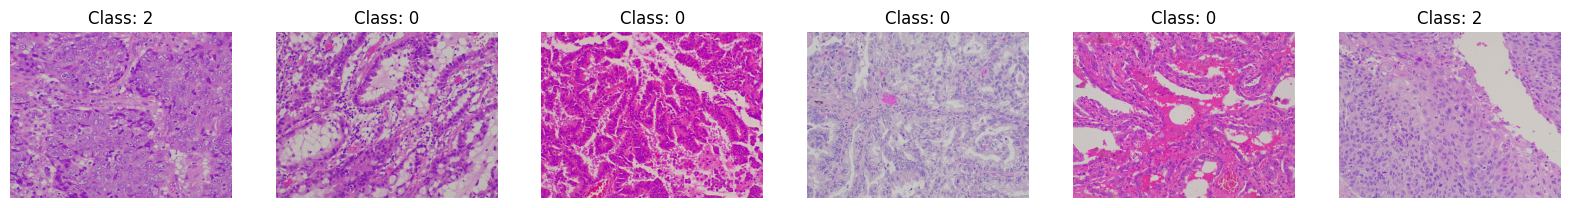

In [4]:
train_generator.show_generator()

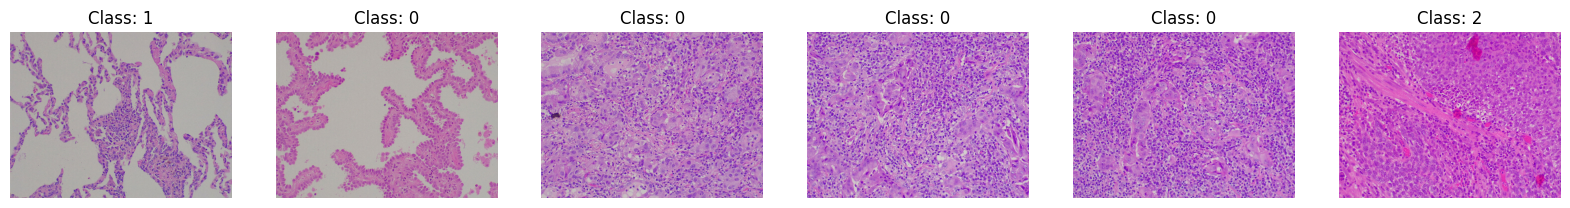

In [5]:
val_generator.show_generator()

## Hyperparameter tuning

In [ ]:
BATCH_SIZE_CANDIDATES = [8, 16] 

LR_CANDIDATES = [5e-5, 1e-5, 3e-5] 

GLOBAL_BEST_LOSS = float('inf')
GLOBAL_BEST_CFG = {}
RESULTS_LOG = []

def hyper_tuning(TARGET_MODEL_NAME):
    print(f"\n--- Hyper-Tuning for {TARGET_MODEL_NAME} ---")
    for batch_size in BATCH_SIZE_CANDIDATES:
        print(f"\n--- Setting up Generators for Batch Size {batch_size} ---")
        
        train_gen, val_gen, test_gen, classes = generator.get_patient_generators(
            resolution, batch_size=batch_size, debug=False, reproducible=True
        )
        
        class_weights = utils.compute_weights(train_gen)

        for lr in LR_CANDIDATES:
            print(f"\n[TUNING] Model: {TARGET_MODEL_NAME} | Batch: {batch_size} | LR: {lr}")
            
            model, model_name = models.get_model(train_gen, TARGET_MODEL_NAME)
            
            print("  > Stage 1: Warm-up (Head only)")
            model = traintest.make_backbone_trainable(model, trainable=False)
            
            model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
                        loss='categorical_crossentropy', 
                        metrics=['accuracy'])
            
            model.fit(train_gen, 
                    validation_data=val_gen, 
                    epochs=8, 
                    class_weight=class_weights,
                    verbose=0) 
            
            print(f"  > Stage 2: Fine-Tuning with LR {lr}")
            model = traintest.make_backbone_trainable(model, trainable=True)
            
            model = traintest.compile_model(model, num_classes=len(classes), init_lr=lr)
            
            run_name = f"{TARGET_MODEL_NAME}_BS{batch_size}_LR{lr}"
            current_log_dir = traintest.get_logdir(TARGET_MODEL_NAME, base_log=f"/content/drive/MyDrive/tuning/{run_name}")
            
            history = traintest.train_model(
                model, 
                train_gen, 
                val_gen, 
                class_weights, 
                current_log_dir, 
                num_epochs=50,  
                patience=10,    
                patience_lr=5
            )
            
            best_run_val_loss = np.min(history.history['val_loss'])
            best_run_epoch = np.argmin(history.history['val_loss']) + 1
            
            print(f"  > Result: Val Loss {best_run_val_loss:.5f} at Epoch {best_run_epoch}")
            
            RESULTS_LOG.append({
                'batch_size': batch_size,
                'lr': lr,
                'val_loss': best_run_val_loss,
                'log_dir': current_log_dir
            })

            if best_run_val_loss < GLOBAL_BEST_LOSS:
                print(f"  *** NEW BEST MODEL FOUND! (Previous: {GLOBAL_BEST_LOSS:.5f}) ***")
                GLOBAL_BEST_LOSS = best_run_val_loss
                GLOBAL_BEST_CFG = {'batch_size': batch_size, 'lr': lr, 'path': current_log_dir}
                
            tf.keras.backend.clear_session()
            del model

    print("\n\n=== TUNING COMPLETE ===")
    print(f"Best Configuration: Batch {GLOBAL_BEST_CFG.get('batch_size')} | LR {GLOBAL_BEST_CFG.get('lr')}")
    print(f"Best Val Loss: {GLOBAL_BEST_LOSS}")

### ResNet50

In [ ]:
hyper_tuning('ResNet50')

### EffetiveNetB3

In [ ]:
hyper_tuning('EfficientNetB3')

### Swin

In [ ]:
hyper_tuning('Swin_KerasCV')

## Train Model

In [ ]:
class_weights = utils.compute_weights(train_generator)

In [ ]:
def train_pipeline(lr, TARGET_MODEL_NAME):
    tf.keras.backend.clear_session()
    gc.collect()
    
    model, model_name = models.get_model(train_generator, TARGET_MODEL_NAME)
            
    print("  > Stage 1: Warm-up (Head only)")
    model = traintest.make_backbone_trainable(model, trainable=False)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    
    model.fit(train_generator, 
                    validation_data=val_generator, 
                    epochs=8, 
                    class_weight=class_weights,
                    verbose=0) 
    
    print(f"  > Stage 2: Fine-Tuning with LR {lr}")
    model = traintest.make_backbone_trainable(model, trainable=True)
    
    model = traintest.compile_model(model, num_classes=len(class_names), init_lr=lr)

    return model, model_name

### ResNet50

In [ ]:
model, model_name = train_pipeline(lr=1e-5, TARGET_MODEL_NAME="ResNet50")

Building model: ResNet50
    Input Shape: (300, 400, 3)
    Number of Classes: 3


In [ ]:
log_dir = traintest.get_logdir(model_name, base_log="/kaggle/working/logs/resnet50")

In [ ]:
history = traintest.train_model(model, train_generator, val_generator, class_weights, log_dir)

### EfficientNetB3

In [ ]:
model, model_name = train_pipeline(lr=3e-5, TARGET_MODEL_NAME="EfficientNetB3")

In [ ]:
log_dir = traintest.get_logdir(model_name, base_log="/kaggle/working/logs/EfficientNetB3")

In [ ]:
history = traintest.train_model(model, train_generator, val_generator, class_weights, log_dir)

### Swin Transformer

In [ ]:
model, model_name = train_pipeline(lr=3e-5, TARGET_MODEL_NAME="Swin_KerasCV")

In [ ]:
log_dir = traintest.get_logdir(model_name, base_log="/kaggle/working/logs/Swin")

In [ ]:
history = traintest.train_model(model, train_generator, val_generator, class_weights, log_dir)

## Evaluate using test data

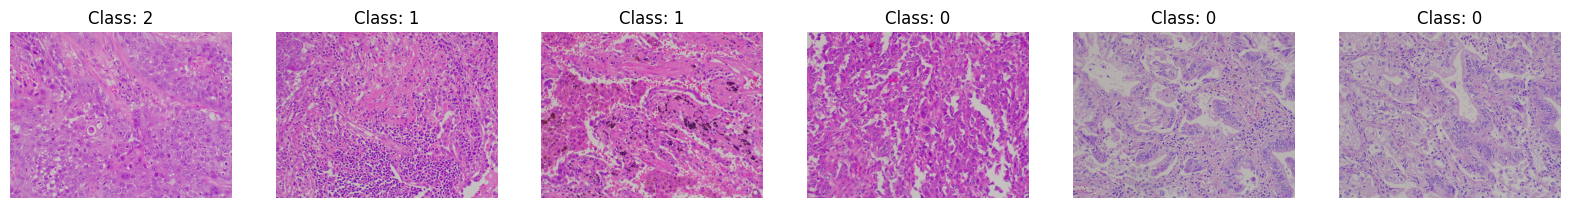

In [ ]:
test_generator.show_generator()

Test AUC: 0.98
Test Accuracy: 0.90
Test Precision: 0.92
Test Recall: 0.87


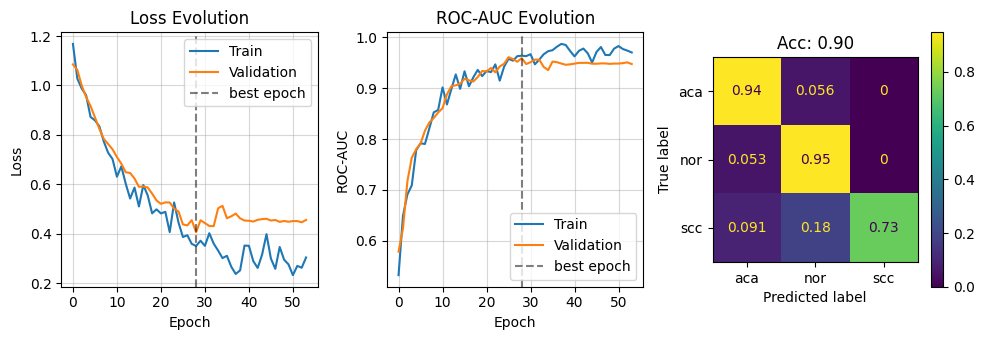

In [ ]:
traintest.metrics_and_test(history, model, test_generator, class_names)

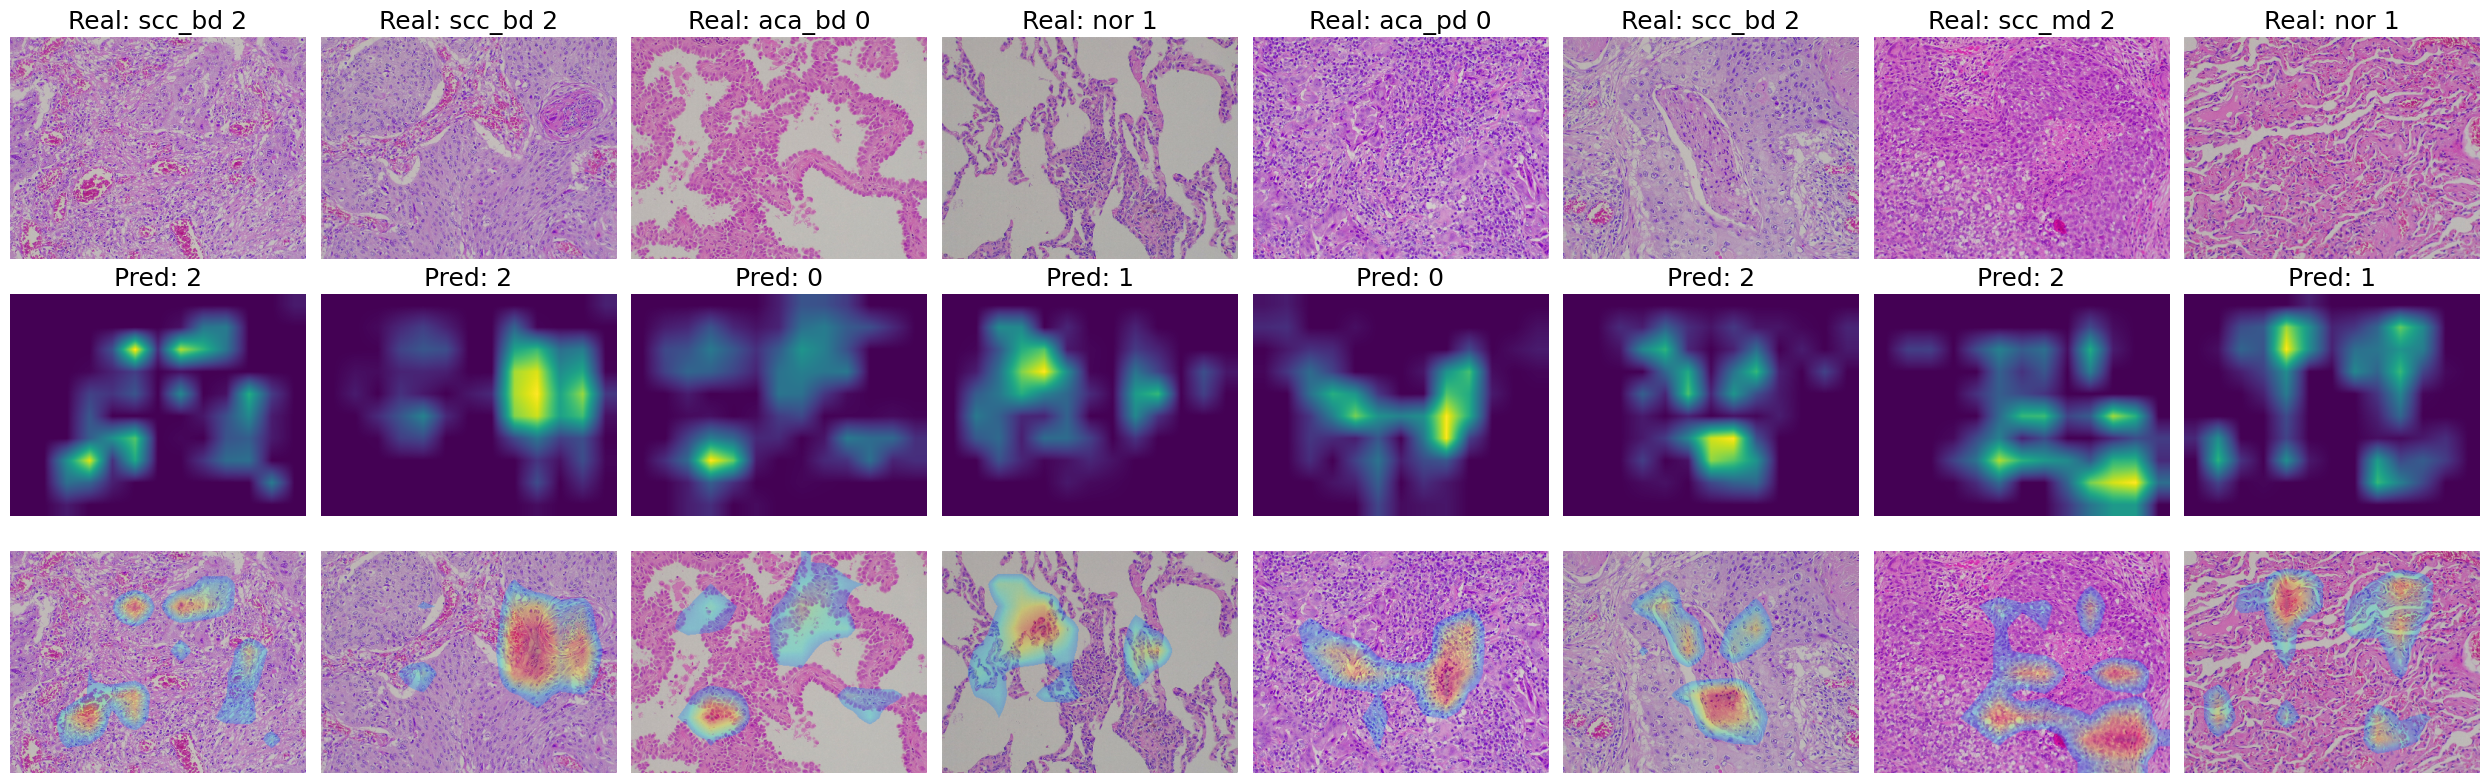

In [ ]:
gradcam.generate_gradcam_samples(model, val_generator)